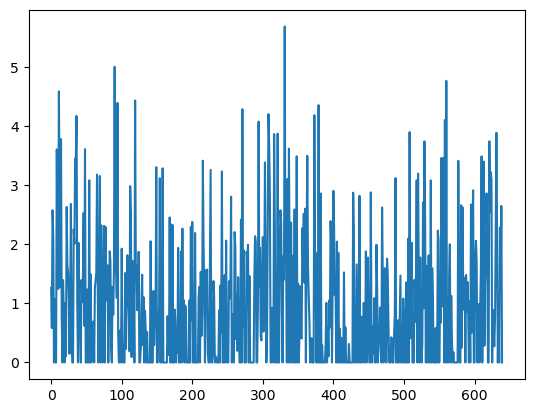

In [74]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

example_init = Path('first_level_fits/3T/exact_lb/sub-001/init_results.csv')

df = pd.read_csv(
    example_init,
    index_col=0,
    header=[0])

df.loc[:, 'gamma_0'].plot()
plt.show()

<Axes: >

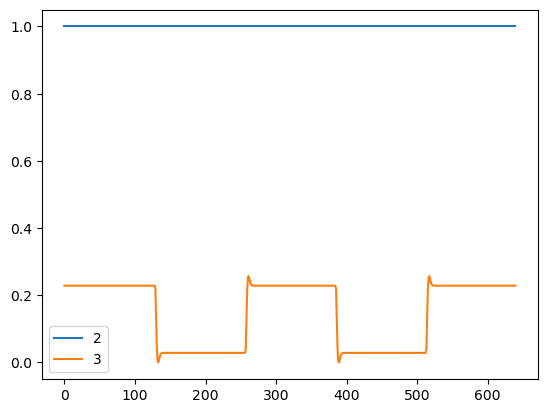

In [75]:
desmat = pd.read_csv(
    'dyn_models/des_mat_3T_exact_lb.csv',
    header=None).iloc[:,-2:]
desmat.plot()

[0.6091839  2.62749777]
0.8363585161001319


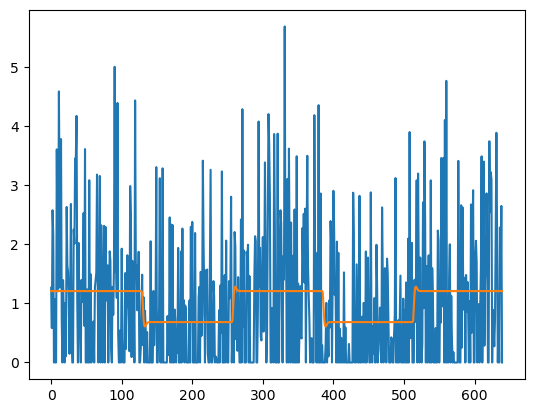

In [76]:
from functools import partial
from scipy.optimize import minimize
import numpy as np

t = desmat.to_numpy()

def model_glm(p,t):
    return np.dot(t,p)

# Dynamic model gradients
def model_glm_grad(p,t):
    return t.T

def default_init(params, tvar):
    func      = partial(model_glm, t=tvar)
    gradfunc  = partial(model_glm_grad, t=tvar)

    def loss(x):
        pred = func(x)
        return np.mean((params - pred)**2)

    def loss_grad(x):
        jac_out = []
        S = func(x)
        for ds in gradfunc(x):
            jac_out.append(np.sum((2 * S * ds) - (2 * params * ds)))
        return np.asarray(jac_out)

    bounds = ((None, None), (None, None))
    return minimize(loss,
                    np.zeros(2),
                    jac=loss_grad,
                    bounds=bounds).x


example_data = df.loc[:, 'gamma_0'].to_numpy()

betas = default_init(
    example_data,
    desmat.to_numpy())

print(betas)
print(betas[1]/np.pi)

plt.plot(example_data)
plt.plot(desmat.to_numpy() @ betas)
plt.show()


0.11159959131366813
[0.02056027 3.84777826 0.47070227]
1.2247858611577243


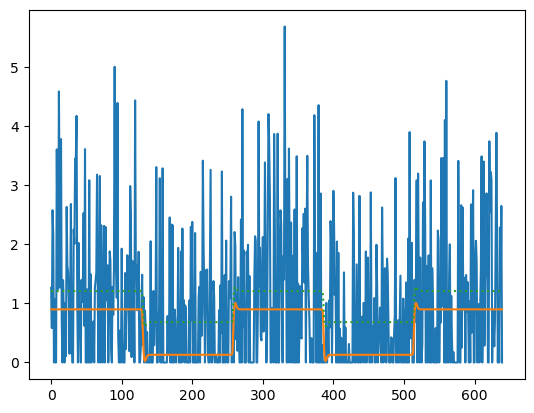

In [77]:
from scipy.stats import norm

def torbit_negloglike(
        y: np.ndarray,
        pred: np.ndarray,
        sigma: float,
        censor_point: float = 0.0) -> float:
    """Calculate the negative log-likelihood for a torbit model

    :param y: Data to fit
    :type y: np.ndarray
    :param pred: fit prediction
    :type pred: np.ndarray
    :param sigma: estimate of noise standard deviation
    :type sigma: float
    :param censor_point: Point at which model is censored (clipped), defaults to 0.0
    :type censor_point: float, optional
    :return: Negative log-likelihood
    :rtype: float
    """
    # mask for uncensored (observed above the censor point)
    uncensored = y > censor_point
    censored = ~uncensored

    # contribution from uncensored: log pdf at observed y
    ll_unc = norm.logpdf(
        y[uncensored],
        loc=pred[uncensored],
        scale=sigma)

    # contribution from censored: log CDF at censor_point
    # P(y* <= censor_point) = Phi((censor_point - mu)/sigma)
    ll_cens = norm.logcdf(
        censor_point,
        loc=pred[censored],
        scale=sigma)

    # Return negative log-likelihood
    return -(np.sum(ll_unc) + np.sum(ll_cens))

def torbit_init(params, tvar, x0, censor_point=0.0):
    func = partial(model_glm, t=tvar)

    def loss(x):
        pred = np.maximum(func(x[:-1]), censor_point)
        sigma = np.exp(x[-1])
        return torbit_negloglike(params, pred, sigma, censor_point=censor_point)
    
    bounds = ((None, None), (None, None), (None, None))
    return minimize(loss,
                    x0,
                    bounds=bounds).x

log_sigma_init = np.log(np.std(example_data - desmat.to_numpy() @ betas))
x0_torbit = np.concatenate([betas, [log_sigma_init]])
print(log_sigma_init)
betas_mle = torbit_init(
    example_data,
    desmat.to_numpy(),
    x0_torbit)

print(betas_mle)
print(betas_mle[1]/np.pi)

plt.plot(example_data)
plt.plot(desmat.to_numpy() @ betas_mle[:-1])
plt.plot(desmat.to_numpy() @ betas, ':')
plt.show()

### A single function to implement above

In [73]:
def model_glm_init(y, t):
    lstsq_init = np.linalg.lstsq(
        t[:, -2:],
        y,
        rcond=None)[0]
    
    log_sigma_init = np.log(np.std(y - t[:, -2:] @ lstsq_init))
    x0_torbit = np.concatenate([lstsq_init, [log_sigma_init]])

    return torbit_init(
        y,
        t[:, -2:],
        x0_torbit,
        censor_point=0.0)[:-1]

torbit_x = model_glm_init(example_data, desmat.to_numpy())
print(torbit_x)
print(torbit_x[1]/np.pi)

[0.07738578 2.85426118]
0.9085395522308971
